**CART (Classification and Regression Trees)**

Максимальная глубина двоичного дерева с 1 000 000 образцов = log2(10^6) = 20 (в большую округлям)

T= (n⋅m⋅log(n)) / S


где:

T — время работы в часах.

S — скорость выполнения алгоритма (например, количество операций в секунду)

In [28]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

presort=True ускоряет обучение, когда меньше 100 000 образцов

In [29]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

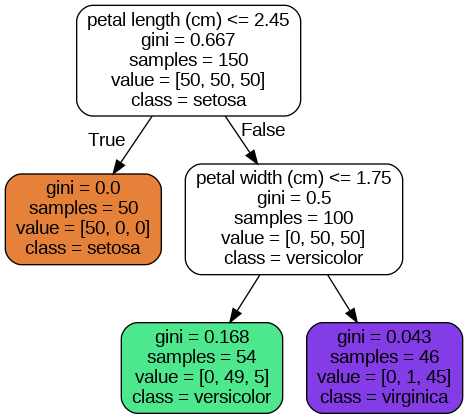

In [30]:
import graphviz

with open("iris_tree.dot") as f:
    dot_graph = f.read()

graph = graphviz.Source(dot_graph)
graph.render("iris_tree")

'iris_tree.pdf'

In [31]:
import subprocess

subprocess.run(["dot", "-Tpng", "iris_tree.dot", "-o", "iris_tree.png"])

CompletedProcess(args=['dot', '-Tpng', 'iris_tree.dot', '-o', 'iris_tree.png'], returncode=0)

In [32]:
tree_clf.predict_proba([[5,1.5]])

array([[0.        , 0.90740741, 0.09259259]])

**Обязательно применять регуляризацию изменяя**

**max_deph, min_samples_split, min_weight_fraction_leaf, max_features**

In [33]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

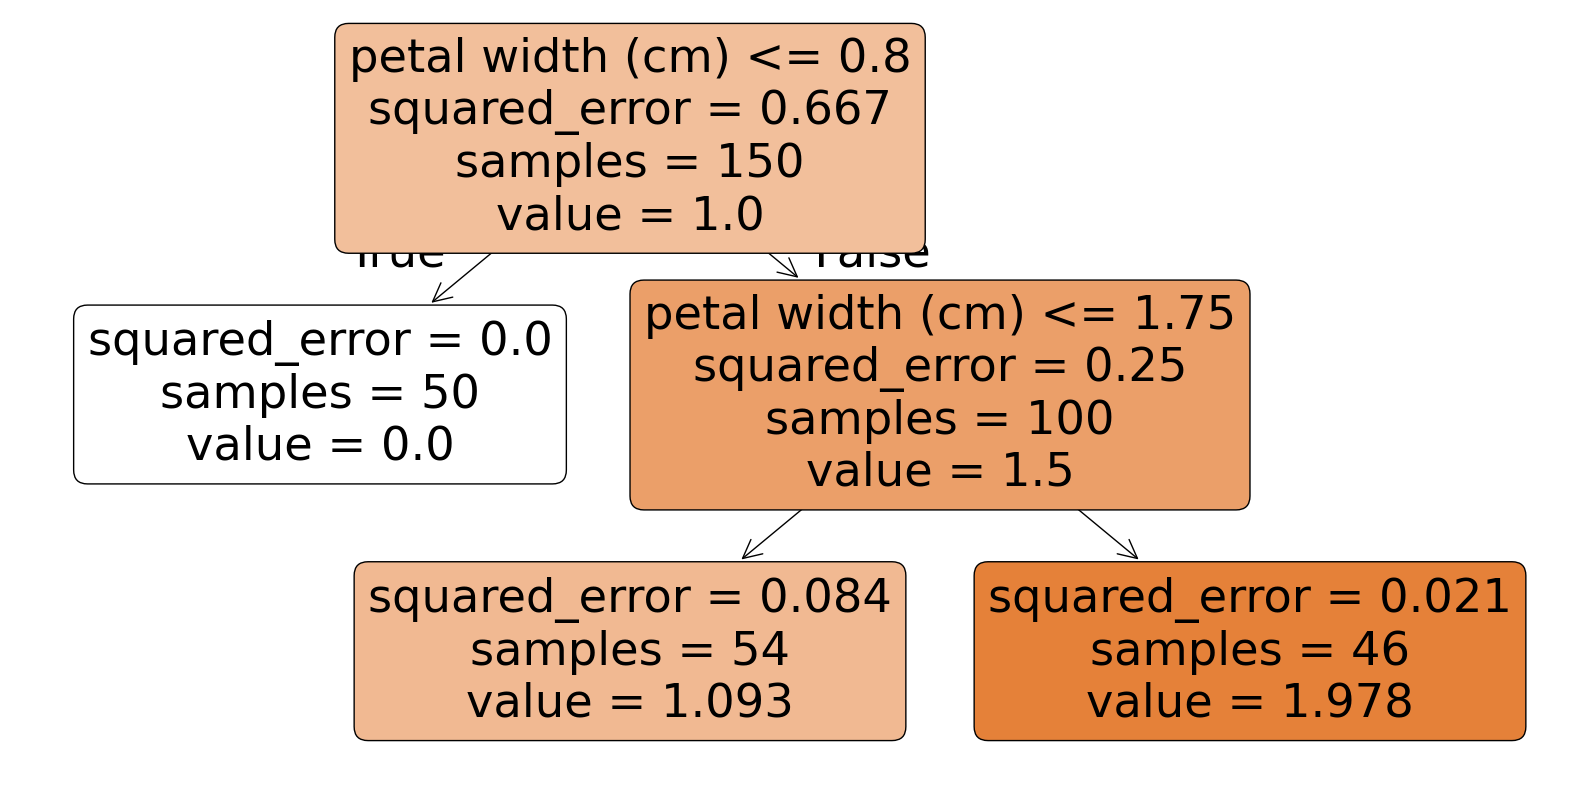

In [34]:
import matplotlib.pyplot as plt

# Визуализация дерева решений
plt.figure(figsize=(20,10))
plot_tree(tree_reg, filled=True, feature_names=iris.feature_names[2:], rounded=True)
plt.show()

In [35]:
print(y[0])
tree_reg.predict([X[0]])

0


array([0.])

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy: 0.8485185185185186


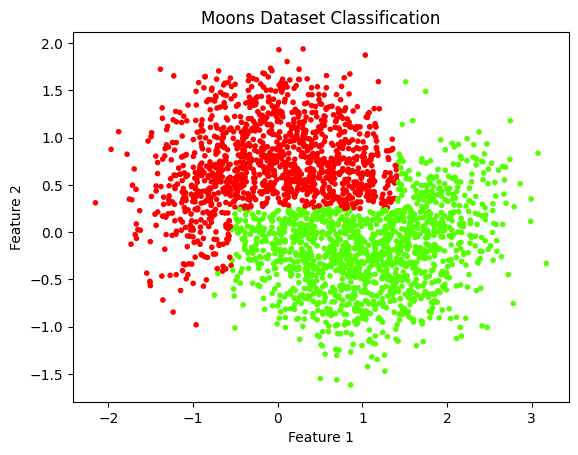

In [36]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=10000, noise=0.4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.27 ,random_state=41)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2, 3, 4, 5, 6,],
    'min_samples_split': [ 2, 3, 4],
    'min_samples_leaf': [1, 2, 4]
}

tree_clf = DecisionTreeClassifier(random_state=41)

grid_search = GridSearchCV(tree_clf, param_grid, cv=3, scoring="accuracy")

grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
best_param = grid_search.best_params_

print("Лучшие параметры:", best_param)

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='prism', marker='.')
plt.title('Moons Dataset Classification')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

**Ансамбли и Смешанный лес**

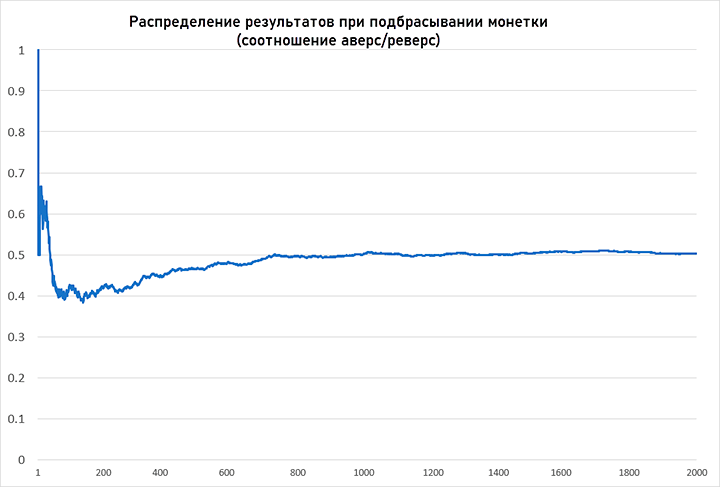

**Hard Voting:** Каждая базовая модель голосует за один класс, и класс с наибольшим количеством голосов выбирается в качестве окончательного предсказания.

**Soft Voting:** Каждая базовая модель предсказывает вероятность принадлежности к каждому классу, и эти вероятности усредняются для получения окончательного предсказания.

In [37]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rnd_clf),
        ('svc', svm_clf)
    ],
    voting='hard' # жёсткое голосование
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [38]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8166666666666667
RandomForestClassifier 0.8251851851851851
SVC 0.8503703703703703
VotingClassifier 0.8474074074074074


In [39]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rnd_clf),
        ('svc', svm_clf)
    ],
    voting='soft' # мягкое голосование
)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8166666666666667
RandomForestClassifier 0.83
SVC 0.8503703703703703
VotingClassifier 0.8485185185185186


Bagging использует бутстрап, для каждого прогнозатора

Бутстрапинг - Это означает, что каждое подмножество данных создается путем случайного выбора образцов из исходного набора данных с возвращением (то есть один и тот же образец может быть выбран несколько раз)

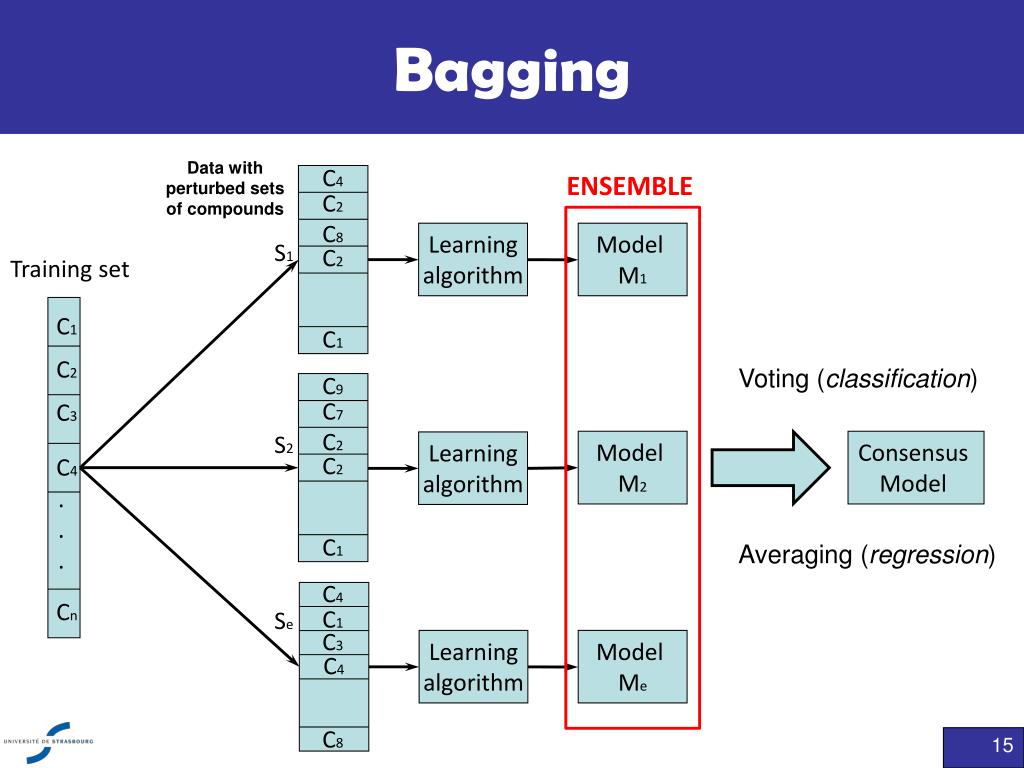

In [40]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier( # мягкое голосование по умолчанию
    DecisionTreeClassifier(),
    n_estimators=500, # количество классификаторов
    max_samples=100, # каждое дерево обучается на 100 образах
    bootstrap=True, # снизу объяснение
    n_jobs=-1 # количество ядер, (-1 указывает на участие всех доступных ядер)
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8503703703703703

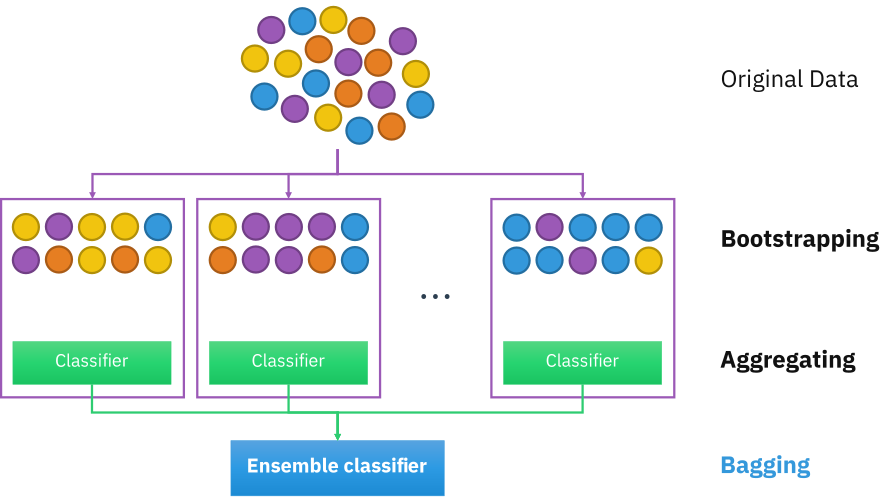

OOB оценка — это метод оценки производительности модели, который использует данные, не включенные в бутстрапированные подмножества, для оценки модели. Это позволяет получить оценку производительности модели без необходимости использования отдельной тестовой выборки.

In [41]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)
bag_clf.fit(X_train, y_train)
print(f"OOB Score: {bag_clf.oob_score_:.4f}")

y_pred = bag_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Real Accuracy Score: {acc:.4f}")

OOB Score: 0.8375
Real Accuracy Score: 0.8259


In [42]:
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       ...,
       [0.        , 1.        ],
       [0.9895288 , 0.0104712 ],
       [0.00558659, 0.99441341]])

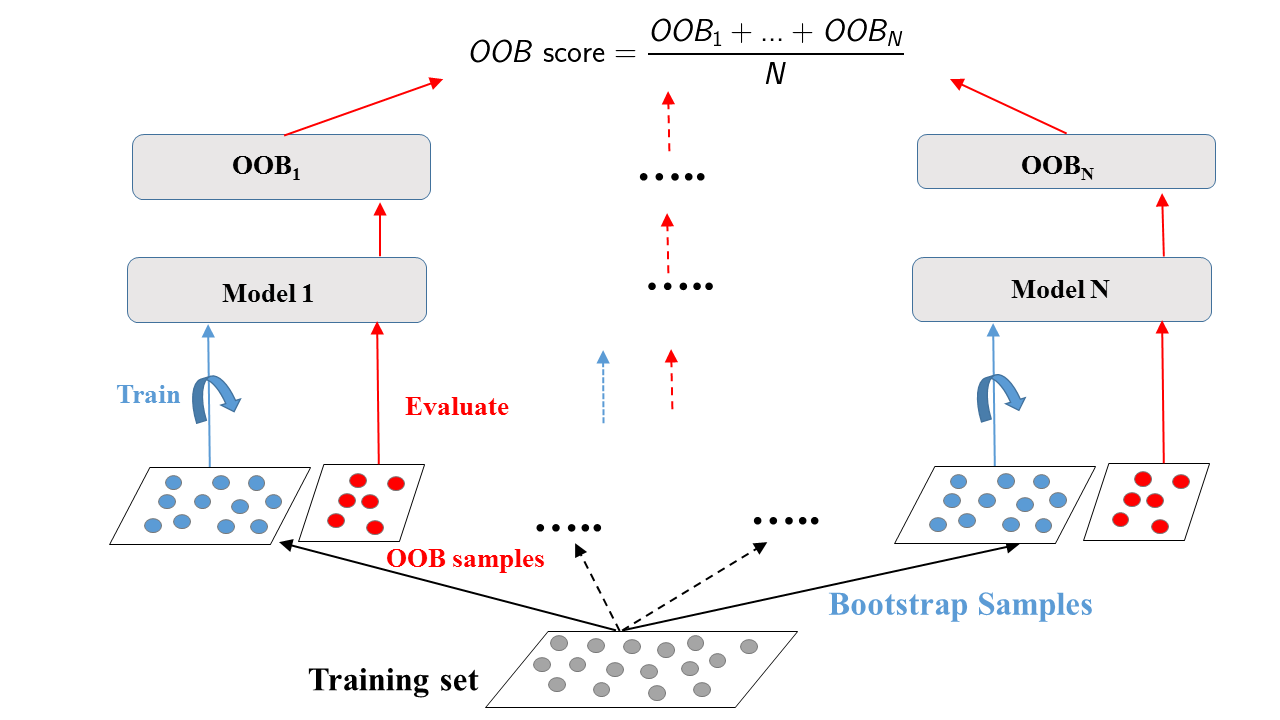

In [43]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16, # количество узлов
                                 n_jobs=-1)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)
print(f"Real Accuracy Score: {acc:.4f}")

Real Accuracy Score: 0.8489


In [44]:
# Тоже самое
# max_samples=1.0 означает, что все образцы будут использоваться для обучения каждого базового эстиматора, что эквивалентно использованию всего набора данных.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500,
    max_samples=1.0,
    bootstrap=True,
    n_jobs=-1
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Real Accuracy Score: {acc:.4f}")

Real Accuracy Score: 0.8481


max_samples используется для: уменьшении дисперсии, ускорение обучения, регуляризации

ExtraTreesClassifier использует множество деревьев решений и случайные пороги для разделения узлов, что делает его более случайным и быстрым по сравнению с RandomForestClassifier

In [45]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

extra_trees_clf = ExtraTreesClassifier(
    n_estimators=500,  # Количество деревьев
    max_features=1.0,  # Максимальное количество признаков для разделения узлов
    bootstrap=True,    # Использование бутстрапинга
    n_jobs=-1          # Использование всех доступных ядер
)

extra_trees_clf.fit(X_train, y_train)

y_pred = extra_trees_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"ExtraTreesClassifier Accuracy Score: {accuracy:.4f}")

ExtraTreesClassifier Accuracy Score: 0.8330


Случайные леса для задачи значимости признаков

Также может вывести значимость пикселей для MNIST

In [46]:
from sklearn.datasets import load_iris

iris = load_iris()
X_iris = iris["data"]
y_iris = iris["target"]
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X_iris, y_iris)
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10356035035067922
sepal width (cm) 0.02431242176621316
petal length (cm) 0.4228841876576251
petal width (cm) 0.44924304022548267


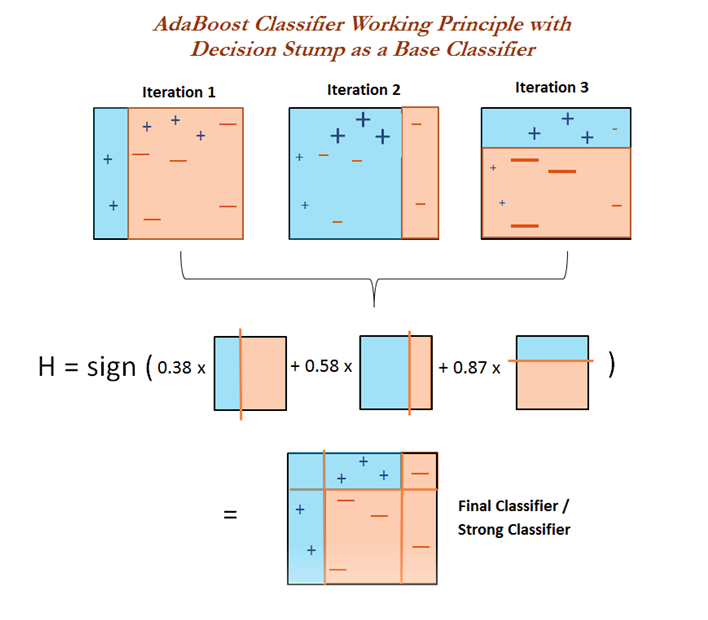

In [47]:
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"AdaBoostClassifier Accuracy Score: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier Accuracy Score: 0.8489


In [54]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

gbrt_clf = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=80,
    learning_rate=0.1
)

gbrt_clf.fit(X_train, y_train)

y_pred = gbrt_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"GradientBoostingClassifier Accuracy Score: {accuracy:.4f}")

GradientBoostingClassifier Accuracy Score: 0.8478


In [56]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Раннее прекращение
gbrt_clf = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=200,
    learning_rate=0.1
)

gbrt_clf.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred1) for y_pred1 in gbrt_clf.staged_predict(X_test)]

bst_n_estimators = np.argmin(errors) + 1

gbrt_best_clf = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=bst_n_estimators,
    learning_rate=0.1
)

gbrt_best_clf.fit(X_train, y_train)

y_pred = gbrt_best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"GradientBoostingClassifier Accuracy Score: {accuracy:.4f}")

GradientBoostingClassifier Accuracy Score: 0.8522


In [57]:
bst_n_estimators

127

gbrt Accuracy Score: 0.8511


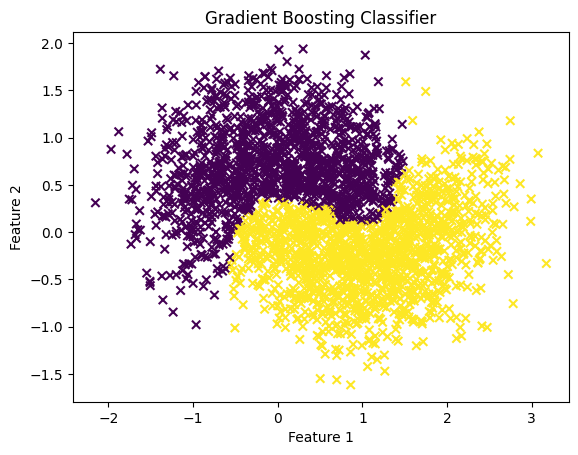

In [58]:
# Создание и обучение GradientBoostingClassifier с ранней остановкой
gbrt = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=200,  # Максимальное количество эстиматоров
    learning_rate=0.1,
    validation_fraction=0.2,  # Доля данных для валидации
    n_iter_no_change=5,  # Количество итераций без улучшения, после которых обучение будет остановлено
    tol=1e-4,  # Толерантность для определения улучшения
    random_state=42,
    warm_start=True  # Использование warm_start для продолжения обучения
)

gbrt.fit(X_train, y_train)

y_pred = gbrt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"gbrt Accuracy Score: {accuracy:.4f}")

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', marker='x')
plt.title('Gradient Boosting Classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

**ИМБА**

улучшенная версия GradientBoosting

In [64]:
import xgboost

xgb_clf = xgboost.XGBClassifier(
    max_depth=2,
    n_estimators=200,  # Максимальное количество эстиматоров
    learning_rate=0.1,
)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"ExtremeGradientBoosting DL Accuracy Score: {accuracy:.4f}")

ExtremeGradientBoosting DL Accuracy Score: 0.8533


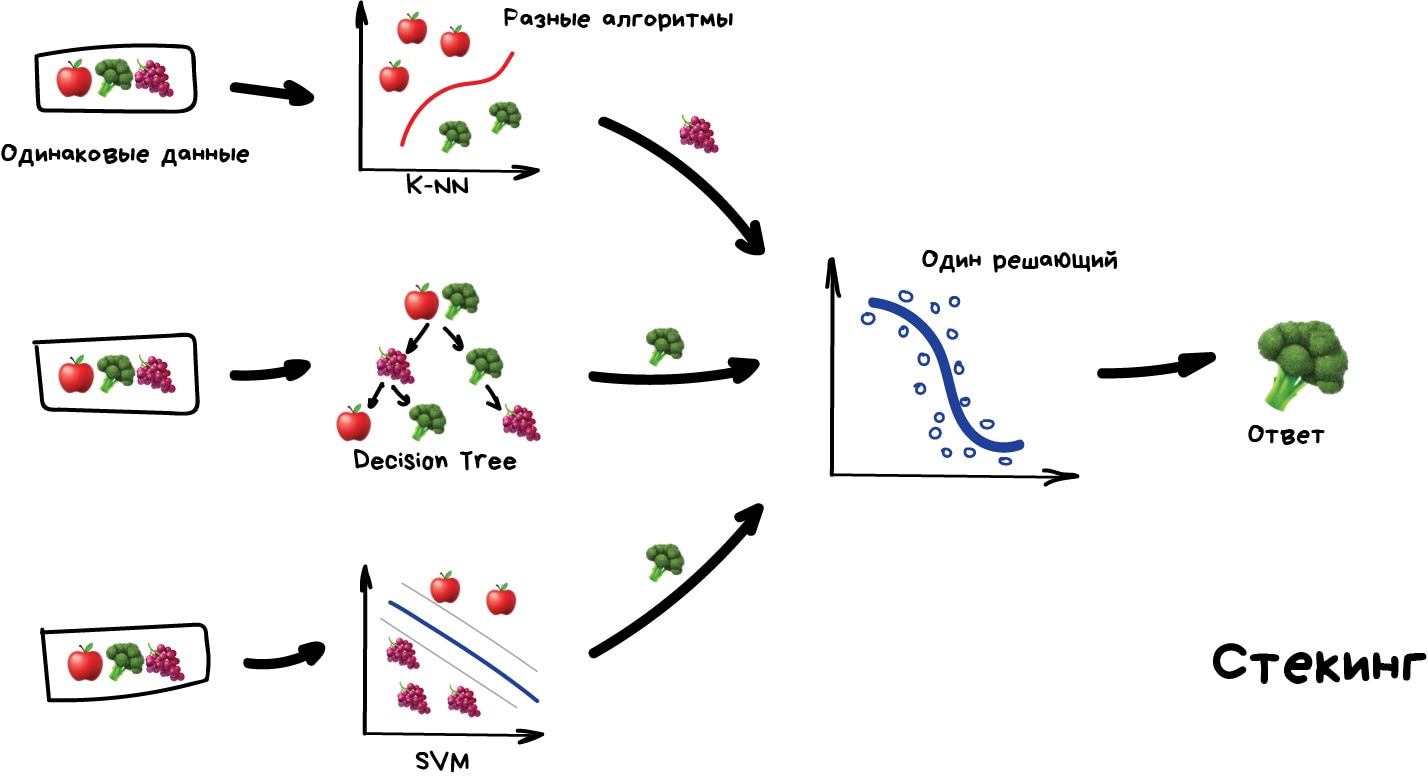

Sklearn не поддерживает стекинг на прямую

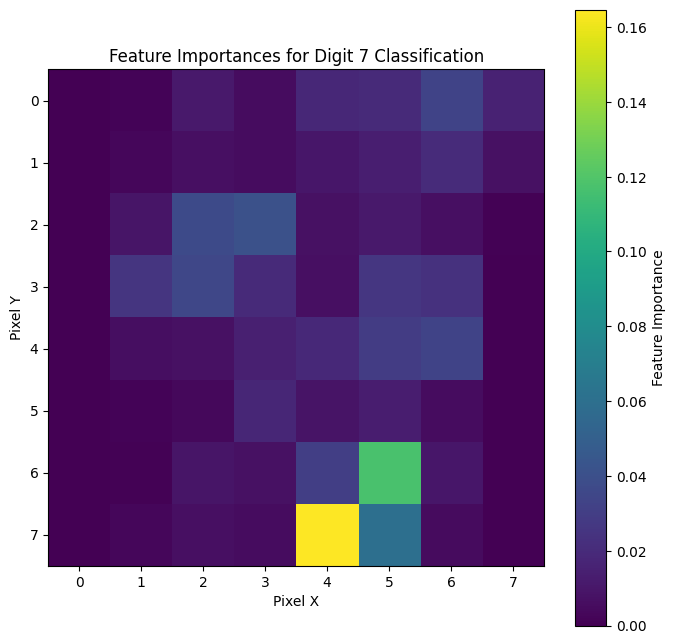

In [83]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

rnd_clf = RandomForestClassifier(n_estimators=130, n_jobs=-1)
rnd_clf.fit(digits["data"], digits["target"] == 7)

feature_importances = rnd_clf.feature_importances_
feature_importances_2d = feature_importances.reshape(digits.images[0].shape)

# for name, score in zip(digits["feature_names"], rnd_clf.feature_importances_):
#   print(name, score)


plt.figure(figsize=(8, 8))
plt.imshow(feature_importances_2d, cmap='viridis')
plt.colorbar(label='Feature Importance')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.title('Feature Importances for Digit 7 Classification')
plt.show()